# How Not to be Fooled by Forecasting Models
**Official Notebook**

1) Simple Autoregressive model equation:
$$
x_t = \alpha * x_{t-1} + s_t + t_t + e_t
$$
2) Dynamic Autoregressive model equation:
$$
x_{t+1} = \alpha * \hat{x}_t + s_{t+1} + t_{t+1} + e_{t+1}
$$
2) Dynamic Autoregressive model for any forecast horizon equation:
$$
x_{t+j} = \alpha * \hat{x}_{t+j-1} + s_{t+j} + t_{t+j} + e_{t+j}
$$

Check out the blog post: https://towardsdatascience.com/how-not-to-be-fooled-by-time-series-forecasting-8044f5838de3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scalecast.Forecaster import Forecaster
import pandas_datareader as pdr

## Make up example data

In [2]:
data = pd.DataFrame(
    {
        'Date':pd.date_range(start='2013-01-01',freq='MS',periods=100)
    },
)

In [3]:
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Target'] = 1

In [4]:
for i,v in data.iterrows():
    if i > 0:
        data.loc[i,'Target'] = (
            .9 * data.loc[i-1,'Target']                 # lag1
            - .05 * np.sin(np.pi * v['Month']/(12/2))   # seasonality
            + .07 * np.cos(np.pi * v['Month']/(12/2))   # seasonality
            + .002 * v['Year']                          # trend
            + np.random.normal(scale=5)                 # resid
        )

In [5]:
data = data.set_index('Date')

In [6]:
data.head()

,Month,Year,Target
Date,,,
2013-01-01,1,2013,1.000000
2013-02-01,2,2013,0.354260
2013-03-01,3,2013,8.590920
2013-04-01,4,2013,5.558896
2013-05-01,5,2013,14.442594


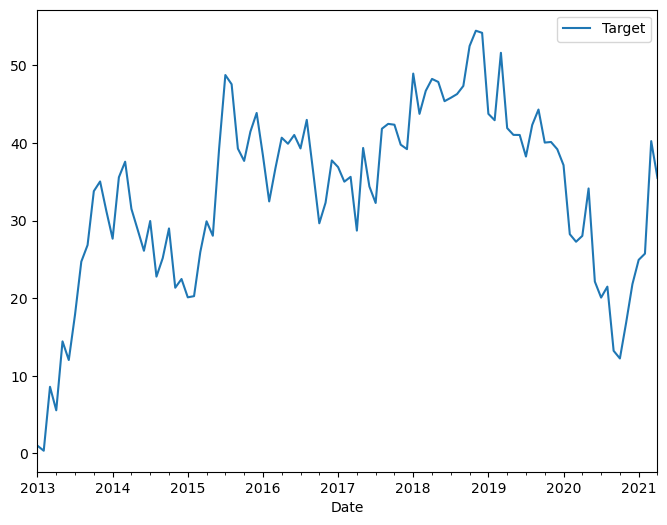

In [7]:
data.plot(y='Target',figsize=(8,6))
plt.show()

### Preprocess for Modeling

In [8]:
data['AR1'] = data['Target'].shift()
data['MonthSin'] = data['Month'].apply(lambda x: np.sin(np.pi * x/(12/2)))
data['MonthCos'] = data['Month'].apply(lambda x: np.cos(np.pi * x/(12/2)))

In [9]:
data_processed = data[['Target','AR1','MonthSin','MonthCos','Year']].dropna()
data_processed.head()

,Target,AR1,MonthSin,MonthCos,Year
Date,,,,,
2013-02-01,0.354260,1.000000,8.660254e-01,5.000000e-01,2013
2013-03-01,8.590920,0.354260,1.000000e+00,6.123234e-17,2013
2013-04-01,5.558896,8.590920,8.660254e-01,-5.000000e-01,2013
2013-05-01,14.442594,5.558896,5.000000e-01,-8.660254e-01,2013
2013-06-01,12.039982,14.442594,1.224647e-16,-1.000000e+00,2013


### Time Series Split

In [10]:
y = data_processed['Target']
X = data_processed.drop('Target',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, shuffle=False)

### Train Linear Model

In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

### Evaluate Results

In [12]:
mean_absolute_error(y_test,pred)

4.655530102852178

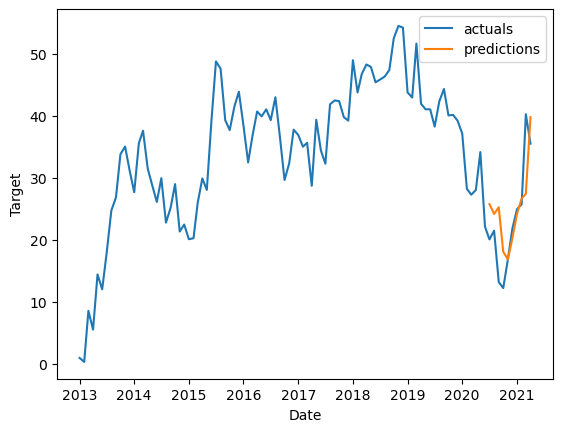

In [13]:
sns.lineplot(y='Target',x='Date',data=data.reset_index(),label='actuals')
sns.lineplot(y=pred,x=data.index[-10:],label='predictions')
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

## Redo with Scalecast

In [14]:
f = Forecaster(y=data['Target'],current_dates=data.index)
f.set_test_length(10)
f.generate_future_dates(10)
f.add_seasonal_regressors('month',sincos=True,raw=False)
f.add_seasonal_regressors('year')
f.add_ar_terms(1)
f

Forecaster(
    DateStartActuals=2013-01-01T00:00:00.000000000
    DateEndActuals=2021-04-01T00:00:00.000000000
    Freq=MS
    N_actuals=100
    ForecastLength=10
    Xvars=['monthsin', 'monthcos', 'year', 'AR1']
    TestLength=10
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

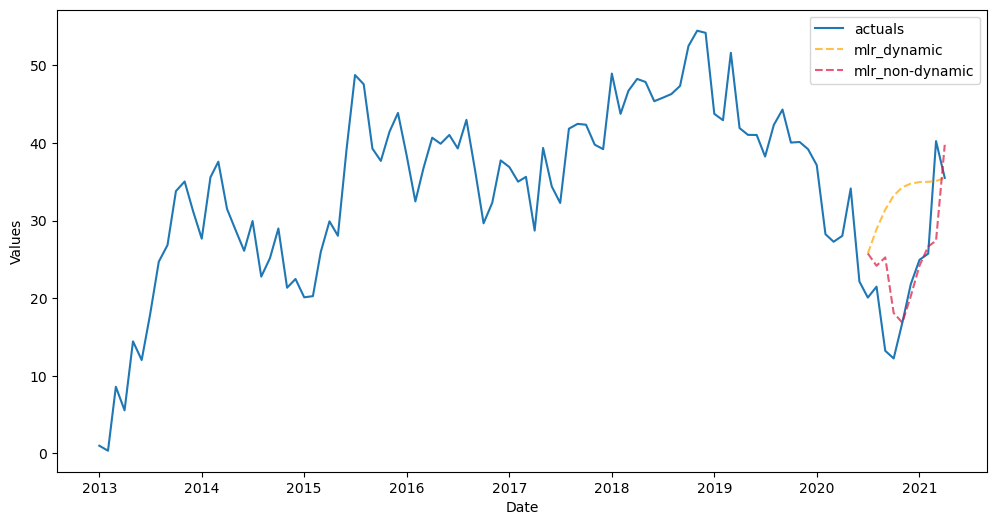

In [15]:
f.set_estimator('mlr')
f.manual_forecast(call_me='mlr_dynamic')
f.manual_forecast(call_me='mlr_non-dynamic',dynamic_testing=False)
f.plot_test_set()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

In [16]:
f.export('model_summaries')[['ModelNickname','TestSetMAE']]

,ModelNickname,TestSetMAE
0,mlr_dynamic,10.704591
1,mlr_non-dynamic,4.655530


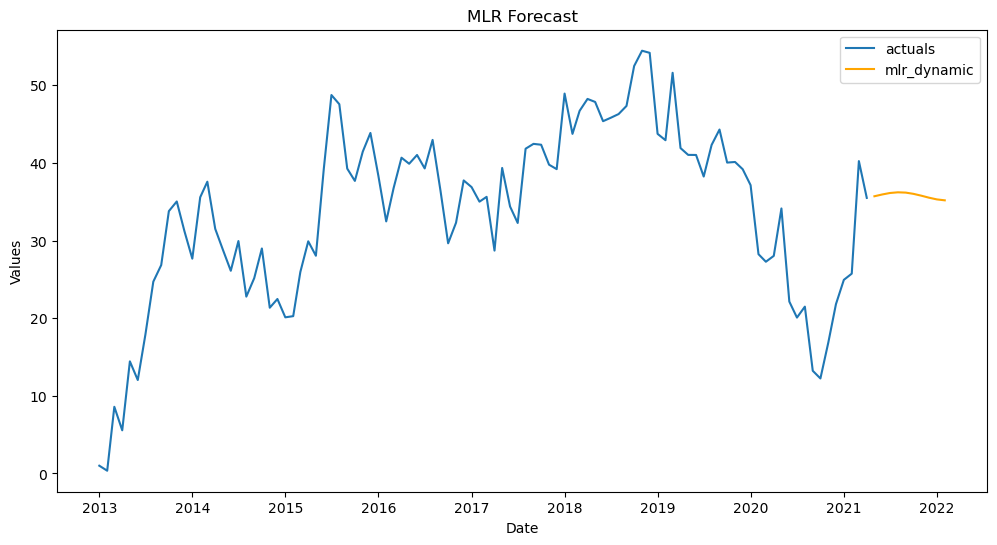

In [17]:
f.plot(models='mlr_dynamic')
plt.title('MLR Forecast')
plt.show()

## Predict the Unpredictable

In [18]:
def prepare_fcst(f):
    f.set_test_length(.3)
    f.generate_future_dates(int(len(f.y)*.3))
    f.add_seasonal_regressors('month',sincos=True,raw=False)
    f.add_seasonal_regressors('year')
    f.add_ar_terms(1)
    return f

def fcst(f):
    f.set_estimator('mlr')
    f.manual_forecast(call_me='mlr_dynamic')
    f.manual_forecast(call_me='mlr_non-dynamic',dynamic_testing=False)
    return f.plot_test_set()

def export(f):
    return f.export('model_summaries')[['ModelNickname','TestSetMAE']]

In [21]:
sp500 = pdr.get_data_yahoo('^GSPC')
btc = pdr.get_data_yahoo('BTC')
covid_affected = pd.read_csv('IAH-Dom.csv')

TypeError: string indices must be integers

In [ ]:
f_sp500 = Forecaster(y=sp500['Close'],current_dates=sp500.index)
prepare_fcst(f_sp500)

In [ ]:
fcst(f_sp500)
plt.title('SP500 Forecast',size=16)
plt.show()

In [ ]:
export(f_sp500)

In [ ]:
f_btc = Forecaster(y=btc['Close'],current_dates=btc.index)
prepare_fcst(f_btc)

In [ ]:
fcst(f_btc)
plt.xticks(rotation = 45)
plt.title('Bitcoin Forecast',size=16)
plt.show()

In [ ]:
export(f_btc)

In [ ]:
f_covid = Forecaster(y=covid_affected['PASSENGERS'],current_dates=covid_affected['Date'])
prepare_fcst(f_covid)

In [ ]:
fcst(f_covid)
plt.title('Airline Passenger Forecast',size=16)
plt.show()

In [ ]:
export(f_covid)